In [25]:
import openeo
import xarray
import matplotlib.pyplot as plt
from PIL import Image

In [26]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with NullAuth>

In [27]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [28]:
coords = {
    "west": 21.04,  # Zmodyfikowane współrzędne
    "south": 52.13,
    "east": 21.07,
    "north": 52.15
}

In [29]:
s2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2024-07-01", "2024-08-01"),  # Zamiast zakresu, podaj konkretny dzień
    spatial_extent={
        **coords,
        "crs": "EPSG:4326",
    },
    bands=["B08", "B11"],
    max_cloud_cover=20,
)

In [30]:
s2_cube.download("load-raw.nc")

In [31]:
# Wczytaj dane z pliku

ds = xarray.load_dataset("load-raw.nc")


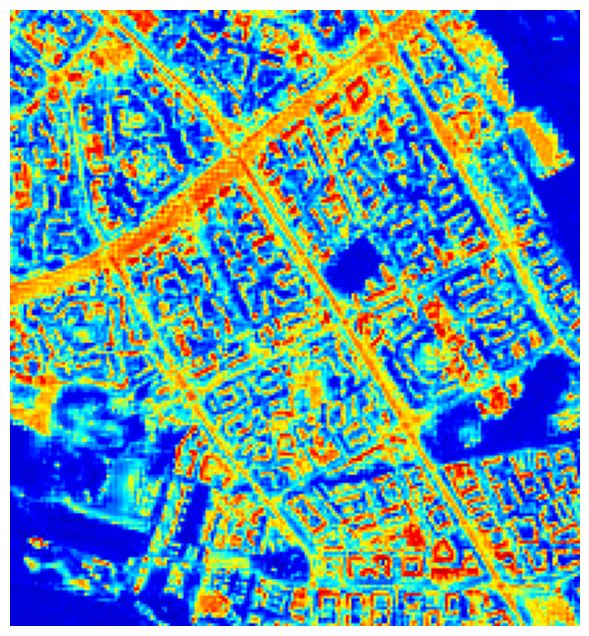

In [32]:

from matplotlib.colors import LinearSegmentedColormap

import numpy as np
# Oblicz NDMI
ds['NDMI'] = (ds['B08'] - ds['B11']) / (ds['B08'] + ds['B11'])

# Konwertuj DataSet na DataArray (bands, t, x, y)
data = ds[["NDMI"]].to_array(dim="bands")

# Definiujemy wartości NDMI i odpowiadające im kolory w formacie RGB
# Przeskalowujemy wartości na przedział [0, 1], który jest wymagany przez LinearSegmentedColormap
moisture_ramps = [
    (-0.8, '#800000'),  # ciemnoczerwony
    (-0.24, '#ff0000'),  # czerwony
    (-0.032, '#ffff00'),  # żółty
    (0.032, '#00ffff'),  # cyjan
    (0.24, '#0000ff'),  # niebieski
    (0.8, '#000080')    # ciemnoniebieski
]

# Tworzymy dostosowaną mapę kolorów
colors = [color for _, color in moisture_ramps]
positions = [(val + 0.8) / 1.6 for val, _ in moisture_ramps]  # Przeskalowujemy wartości NDMI na zakres [0, 1]

cmap = LinearSegmentedColormap.from_list("custom_moisture_cmap", list(zip(positions, colors)))



# Wyciągnięcie danych NDMI dla pierwszego dnia
ndmi_data = data.isel(bands=0, t=0).values  # Wartości NDMI dla pierwszego dnia

# Znormalizowanie danych do zakresu [0, 1]
ndmi_data_normalized = (ndmi_data + 0.8) / 1.6  # Przekształcamy na zakres [0, 1]

# Zastosowanie cmap do uzyskania kolorów
colored_image = (cmap(ndmi_data_normalized)[:, :, :3] * 255).astype(np.uint8)  # RGB
alpha_channel = np.ones((colored_image.shape[0], colored_image.shape[1], 1), dtype=np.uint8) * 255  # Pełna nieprzezroczystość
rgba_image = np.concatenate((colored_image, alpha_channel), axis=2)  # Łączymy RGB z alpha

# Tworzenie obrazu
image = Image.fromarray(rgba_image, mode='RGBA')

# Zapisanie obrazu do pliku PNG
image.save("maps/ndmi_streets_clean.png")

from PIL import Image
import matplotlib.pyplot as plt

# Wczytanie obrazu
image_path = "maps/ndmi_streets_clean.png"
img = Image.open(image_path)

# Wyświetlenie obrazu w Jupyter Notebook
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')  # Ukrycie osi
plt.show()

Width: 207, Height: 224


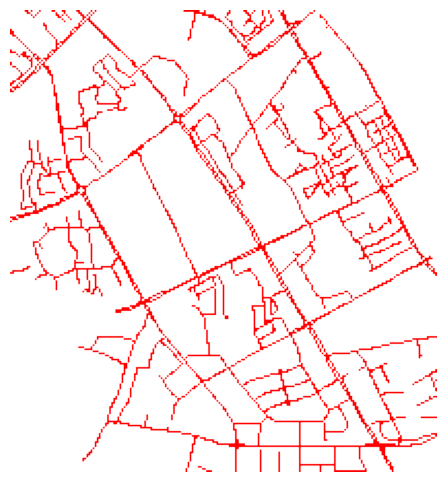

In [33]:
import os
import numpy as np
import geopandas as gpd
import osmnx as ox
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


# Wczytanie obrazu
image_path = "maps/ndmi_streets_clean.png"
img = Image.open(image_path)

# Sprawdzenie wymiarów obrazu
width, height = img.size
print(f"Width: {width}, Height: {height}")

# Definicja miejsca: Ursynów, Warszawa, Polska
place_name = "Ursynow, Warsaw, Poland"

# Pobranie grafu ulicznego dla Ursynowa
G = ox.graph_from_place(place_name, network_type='drive')

# Pobranie krawędzi (ulic) z grafu
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Ustawienia obrazu
#width, height = 500, 500  # Rozmiar obrazu
background_color = (255, 255, 255, 0)  # Przezroczyste tło
line_color = (255, 0, 0, 255)  # Czerwony kolor linii z pełną nieprzezroczystością

# Tworzenie nowego obrazu z przezroczystym tłem (RGBA)
image = Image.new("RGBA", (width, height), background_color)
draw = ImageDraw.Draw(image)

# Ustawienia granic geograficznych dla Ursynowa
lon_min, lon_max = coords["west"], coords["east"]
lat_min, lat_max = coords["south"], coords["north"]

# Funkcja do konwersji współrzędnych geograficznych na piksele
def geo_to_pixel(lon, lat, width, height, lon_min, lon_max, lat_min, lat_max):
    x = int((lon - lon_min) / (lon_max - lon_min) * width)
    y = height - int((lat - lat_min) / (lat_max - lat_min) * height)  # Inwersja osi y
    return x, y

# Rysowanie ulic na obrazie
for _, row in edges.iterrows():
    coords = row['geometry'].coords
    for i in range(len(coords) - 1):
        x1, y1 = geo_to_pixel(coords[i][0], coords[i][1], width, height, lon_min, lon_max, lat_min, lat_max)
        x2, y2 = geo_to_pixel(coords[i + 1][0], coords[i + 1][1], width, height, lon_min, lon_max, lat_min, lat_max)
        draw.line((x1, y1, x2, y2), fill=line_color, width=1)

# Zapisanie obrazu do pliku PNG z przezroczystym tłem
os.makedirs("maps", exist_ok=True)
image_path = "maps/kabaty_streets_pixelated_transparent.png"
image.save(image_path, "PNG")

# Wyświetlenie obrazu w Jupyter Notebook
img = Image.open(image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')  # Ukrycie osi
plt.show()


Width: 207, Height: 224


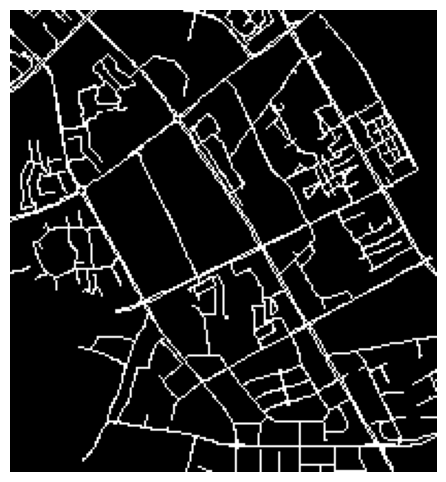

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


In [34]:
import os
import numpy as np
import geopandas as gpd
import osmnx as ox
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch

# Wczytanie obrazu
image_path = "maps/kabaty_streets_pixelated_transparent.png"
img = Image.open(image_path).convert("RGBA")  # Upewnij się, że obraz ma kanał alpha

# Sprawdzenie wymiarów obrazu
width, height = img.size
print(f"Width: {width}, Height: {height}")

# Tworzenie macierzy numpy
data = np.array(img)

# Tworzenie macierzy boolowskiej
# Czerwony kolor w RGBA to (255, 0, 0, 255)
# Przezroczysty kolor to (255, 255, 255, 0) lub (0, 0, 0, 0)
red_pixels = (data[:, :, 0] == 255) & (data[:, :, 1] == 0) & (data[:, :, 2] == 0) & (data[:, :, 3] == 255)
transparent_pixels = (data[:, :, 3] == 0)

# Stworzenie macierzy boolowskiej (1 dla czerwonych pikseli, 0 dla przezroczystych)
bool_array = np.zeros((height, width), dtype=np.bool_)
bool_array[red_pixels] = 1  # Ustawienie czerwonych pikseli na 1

# Konwersja na tensor PyTorch
torch_tensor = torch.tensor(bool_array, dtype=torch.bool)

# Zapisanie macierzy numpy jako plik .npy (opcjonalne)
np.save("maps/kabaty_streets_bool_array.npy", bool_array)

# Wyświetlenie obrazu w Jupyter Notebook
plt.figure(figsize=(6, 6))
plt.imshow(bool_array, cmap='gray')  # Użyj szarości dla wyświetlenia
plt.axis('off')  # Ukrycie osi
plt.show()

# Wydrukowanie tensoru PyTorch
print(torch_tensor)


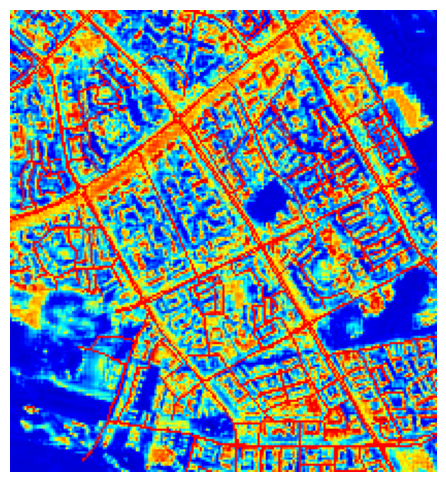

In [35]:
from PIL import Image

# Wczytanie obrazów
background = Image.open("maps/ndmi_streets_clean.png")
overlay = Image.open("maps/kabaty_streets_pixelated_transparent.png")

# Upewnij się, że oba obrazy mają ten sam rozmiar
if background.size != overlay.size:
    overlay = overlay.resize(background.size)  # Zmiana rozmiaru overlay, jeśli to konieczne

# Nałożenie overlay na background
# Ostatni argument 'overlay' to maska alpha, która pozwala zachować przezroczystość
background.paste(overlay, (0, 0), overlay)

# Zapisanie wyniku
background.save("maps/combined_image.png")


# Wyświetlenie obrazu w Jupyter Notebook
img = Image.open("maps/combined_image.png")
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')  # Ukrycie osi
plt.show()


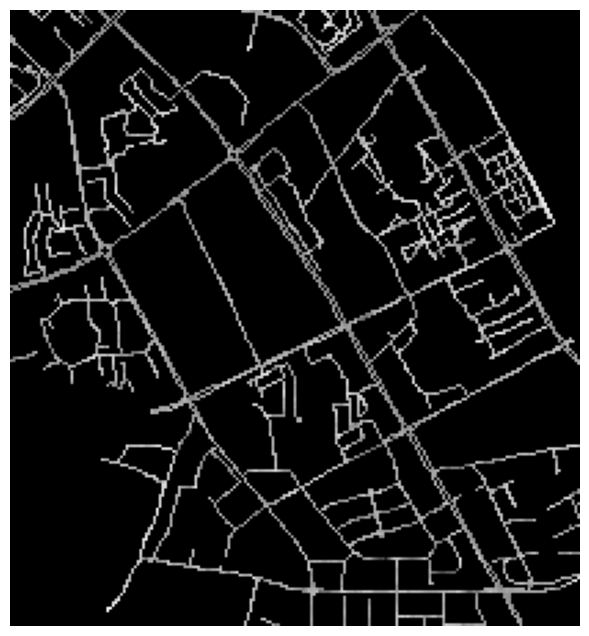

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [36]:
import os
import numpy as np
import geopandas as gpd
import osmnx as ox
from PIL import Image
import matplotlib.pyplot as plt
import torch
from matplotlib.colors import LinearSegmentedColormap

# Oblicz NDMI
ds['NDMI'] = (ds['B08'] - ds['B11']) / (ds['B08'] + ds['B11'])

# Konwertuj DataSet na DataArray (bands, t, x, y)
data = ds[["NDMI"]].to_array(dim="bands")

# Wyciągnięcie danych NDMI dla pierwszego dnia
ndmi_data = data.isel(bands=0, t=0).values  # Wartości NDMI dla pierwszego dnia
ndmi_tensor = torch.tensor(ndmi_data, dtype=torch.float32)

# Znormalizowanie danych do zakresu [0, 1]
min_ndmi = torch.min(ndmi_tensor)
max_ndmi = torch.max(ndmi_tensor)
# Przekształcenie danych NDMI na zakres [1, 0.1]
ndmi_data_normalized = ((ndmi_tensor.numpy() - min_ndmi.numpy()) * 0.9) / (max_ndmi.numpy() - min_ndmi.numpy()) + 0.1

# Tworzenie macierzy NDMI jako tensor PyTorch z znormalizowanych danych
ndmi_tensor = torch.tensor(ndmi_data_normalized, dtype=torch.float32)


# Wczytanie obrazu z ulicami
streets_image_path = "maps/kabaty_streets_pixelated_transparent.png"
streets_img = Image.open(streets_image_path).convert("RGBA")

# Sprawdzenie wymiarów obrazu z ulicami
streets_data = np.array(streets_img)

# Tworzenie maski dla czerwonych pikseli
red_pixels = (streets_data[:, :, 0] == 255) & (streets_data[:, :, 1] == 0) & (streets_data[:, :, 2] == 0) & (streets_data[:, :, 3] == 255)
mask = np.zeros(ndmi_tensor.shape, dtype=np.bool_)
mask[red_pixels] = 1  # Ustawienie czerwonych pikseli na 1

# Stworzenie macierzy NDMI z maską
masked_ndmi = ndmi_tensor * torch.tensor(mask, dtype=torch.float32)  # Nakładanie maski

# Zapisanie macierzy NDMI jako plik .npy (opcjonalne)
np.save("maps/masked_ndmi.npy", masked_ndmi.numpy())

# Wyświetlenie wynikowej macierzy NDMI w Jupyter Notebook
plt.figure(figsize=(8, 8))
plt.imshow(masked_ndmi.numpy(), cmap='gray')  # Użyj szarości dla wyświetlenia
plt.axis('off')  # Ukrycie osi
plt.show()

# Wydrukowanie tensoru PyTorch
print(masked_ndmi)


Visited positions: [(110, 120), (109, 119), (108, 119), (107, 118), (106, 118), (105, 117), (105, 116), (104, 117), (103, 116), (102, 115), (102, 114), (101, 115), (100, 114), (99, 113), (98, 112), (99, 112), (98, 111), (97, 112), (96, 111), (95, 110), (94, 110), (93, 109), (92, 108), (91, 108), (90, 107), (89, 106), (88, 106), (87, 105), (86, 104), (85, 103), (84, 103), (83, 102), (82, 102), (81, 101), (80, 100), (79, 100), (78, 99), (77, 98), (78, 98), (77, 97), (76, 98), (75, 97), (74, 96), (73, 96), (72, 95), (71, 94), (70, 94), (69, 93), (68, 92), (67, 91), (66, 90), (65, 90), (64, 89), (63, 89), (62, 88), (61, 88), (60, 87), (59, 87), (58, 86), (57, 85), (56, 84), (55, 84), (54, 83), (55, 82), (54, 82), (53, 82), (52, 82), (51, 83), (50, 83), (49, 84), (48, 85), (47, 86), (47, 87), (46, 88), (45, 89), (46, 89), (45, 90), (44, 91), (43, 91), (42, 92), (41, 93), (41, 94), (40, 95), (39, 96), (38, 97), (39, 97), (38, 98), (37, 99), (36, 100), (35, 101), (34, 102), (33, 103), (33, 10

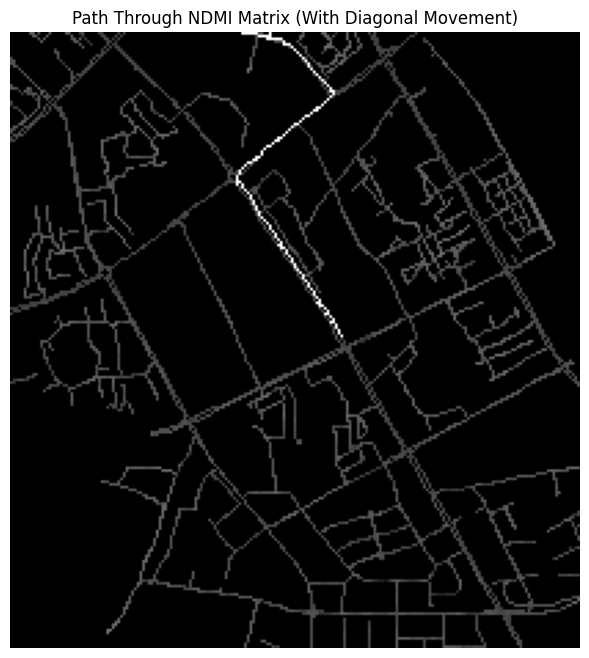

In [37]:
import numpy as np
import torch

def find_path_with_diagonal(ndmi_tensor, start_pos, num_steps=1000):
    """
    Function to find a path through an NDMI matrix, avoiding black pixels,
    moving through pixels with the lowest brightness, without returning to previously visited points.
    Also allows diagonal movement.
    
    :param ndmi_tensor: 2D tensor containing pixel brightness values.
    :param start_pos: Tuple (x, y) representing the start position.
    :param num_steps: Number of pixels to move through.
    
    :return: List of visited positions.
    """
    # Define movement directions (up, down, left, right, and diagonal)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),     # Up, down, left, right
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]  # Diagonal directions
    
    # Get the shape of the NDMI tensor
    height, width = ndmi_tensor.shape
    
    # Initialize current position
    current_pos = start_pos
    
    # List to store the path and set to track visited points
    path = [current_pos]
    visited = set([current_pos])  # Track visited pixels to avoid returning to them
    
    # Perform num_steps movements
    for step in range(num_steps):
        x, y = current_pos
        current_value = ndmi_tensor[x, y]
        
        # Store the neighbors (valid non-black and unvisited neighbors only)
        neighbors = []
        for dx, dy in directions:
            new_x, new_y = x + dx, y + dy
            if 0 <= new_x < height and 0 <= new_y < width:  # Ensure the neighbor is within bounds
                neighbor_value = ndmi_tensor[new_x, new_y]
                if neighbor_value > 0 and (new_x, new_y) not in visited:  # Avoid black pixels and visited pixels
                    neighbors.append(((new_x, new_y), neighbor_value))
        
        if not neighbors:
            # No more valid moves, end early
            break
        
        # Move to the neighbor with the lowest brightness value
        neighbors.sort(key=lambda n: n[1])  # Sort by brightness (second element of tuple)
        next_pos, _ = neighbors[0]
        
        # Update current position
        current_pos = next_pos
        path.append(current_pos)
        visited.add(current_pos)  # Mark the position as visited
    
    return path


# Example usage:
# Assuming 'masked_ndmi' is your NDMI tensor (PyTorch tensor) and start_pos is the starting pixel
start_pos = (110, 120)  # Example starting position
path = find_path_with_diagonal(masked_ndmi, start_pos, num_steps=1000)

# Print the path
print("Visited positions:", path)

# Optionally, visualize the path
import matplotlib.pyplot as plt

# Create a copy of the NDMI data to visualize the path
ndmi_with_path = masked_ndmi.clone().numpy()

# Mark the path in the NDMI matrix (set the path pixels to a specific value, e.g., 2.0)
for x, y in path:
    ndmi_with_path[x, y] = 2.0

# Plot the NDMI matrix with the path
plt.figure(figsize=(8, 8))
plt.imshow(ndmi_with_path, cmap='gray')
plt.axis('off')
plt.title("Path Through NDMI Matrix (With Diagonal Movement)")
plt.show()


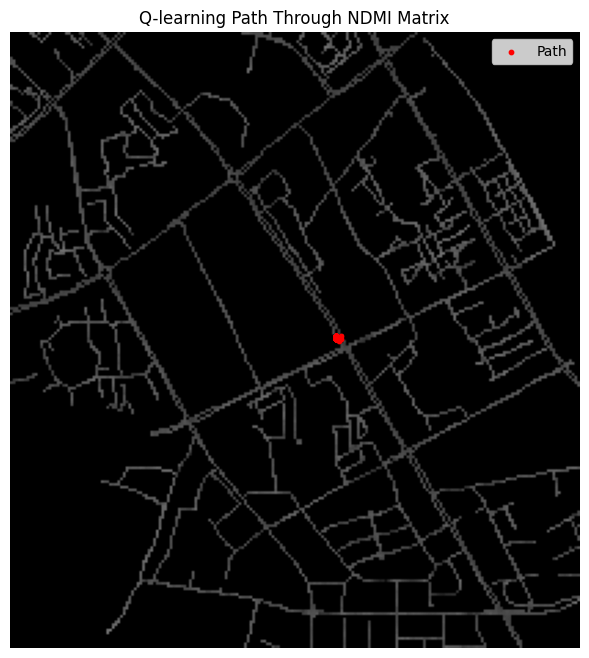

In [49]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Q-learning parameters
alpha = 0.1    # Learning rate
gamma = 0.9    # Discount factor
epsilon = 0.9  # Exploration rate (epsilon-greedy policy)
num_episodes = 5000
num_steps = 1000  # Maximum number of steps in one episode

# Define movement directions (up, down, left, right, and diagonals)
directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

# Q-table initialization
def initialize_q_table(ndmi_tensor):
    height, width = ndmi_tensor.shape
    return np.zeros((height, width, len(directions)))

# Function to get reward based on the current position
def get_reward(ndmi_tensor, x, y):
    return ndmi_tensor[x, y]  # Return the brightness value as the reward

# Epsilon-greedy policy: choose action based on Q-values or randomly
def choose_action(q_table, x, y):
    if random.uniform(0, 1) < epsilon:
        # Exploration: choose a random action
        return random.randint(0, len(directions) - 1)
    else:
        # Exploitation: choose the best action based on Q-values
        return np.argmax(q_table[x, y])

# Update Q-values using the Q-learning update rule
def update_q_value(q_table, x, y, action, reward, new_x, new_y):
    best_future_q = np.max(q_table[new_x, new_y])  # Get the maximum Q-value of the next state
    current_q = q_table[x, y, action]
    q_table[x, y, action] = current_q + alpha * (reward + gamma * best_future_q - current_q)

# Q-learning algorithm
def q_learning(ndmi_tensor, start_pos, num_episodes, num_steps):
    q_table = initialize_q_table(ndmi_tensor)
    height, width = ndmi_tensor.shape
    
    for episode in range(num_episodes):
        # Reset the environment
        x, y = start_pos
        visited = set([(x, y)])  # Keep track of visited positions
        
        for step in range(num_steps):
            # Choose action (epsilon-greedy)
            action = choose_action(q_table, x, y)
            
            # Get the new position based on the chosen action
            dx, dy = directions[action]
            new_x, new_y = x + dx, y + dy
            
            # Check if the new position is within bounds
            if 0 <= new_x < height and 0 <= new_y < width and (new_x, new_y) not in visited:
                visited.add((new_x, new_y))
                reward = get_reward(ndmi_tensor, new_x, new_y)
                
                # Update the Q-table
                update_q_value(q_table, x, y, action, reward, new_x, new_y)
                
                # Move to the new position
                x, y = new_x, new_y
            else:
                # If invalid move, give a negative reward and break
                reward = -1
                break
        
    return q_table

# Use the Q-table to follow the optimal path
def follow_optimal_path(q_table, start_pos, num_steps):
    path = [start_pos]
    x, y = start_pos
    
    for _ in range(num_steps):
        # Choose the best action based on the learned Q-values
        action = np.argmax(q_table[x, y])
        dx, dy = directions[action]
        new_x, new_y = x + dx, y + dy
        
        # Check if new position is within bounds
        if 0 <= new_x < q_table.shape[0] and 0 <= new_y < q_table.shape[1]:
            path.append((new_x, new_y))
            x, y = new_x, new_y
        else:
            break  # Stop if the move goes out of bounds
    
    return path

# Example usage:
# Assuming 'masked_ndmi' is your NDMI tensor (PyTorch tensor) and start_pos is the starting pixel
start_pos = (110, 120)  # Example starting position
masked_ndmi_numpy = masked_ndmi.numpy()

# Train the Q-learning agent
q_table = q_learning(masked_ndmi_numpy, start_pos, num_episodes, num_steps)

# Follow the learned optimal path
path = follow_optimal_path(q_table, start_pos, num_steps)

# --- Visualization ---

# Create a copy of the NDMI matrix for visualization
ndmi_with_path = masked_ndmi_numpy.copy()

# Mark the path in the NDMI matrix (e.g., set to 2.0 for visualization purposes)
for i, (x, y) in enumerate(path):
    ndmi_with_path[x, y] = 2.0  # You can adjust this value to visualize the path

# Plot the NDMI matrix with the path
plt.figure(figsize=(8, 8))
plt.imshow(ndmi_with_path, cmap='gray')
plt.scatter([y for x, y in path], [x for x, y in path], c='red', s=10, label='Path')
plt.title("Q-learning Path Through NDMI Matrix")
plt.axis('off')
plt.legend()
plt.show()
